In [ ]:
!pip3 install scikit-learn
!pip3 install torch
!pip3 install torchinfo


In [ ]:
!pip3 install google-colab

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.5 MB/s eta 0:00:00


In [57]:
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# only for running locally
#dfs = []
#for filename in os.listdir('features_ring'):
#    if filename[-4:] == '.tsv':
#        dfs.append(pd.read_csv('features_ring/' + filename, sep='\t'))
#df = pd.concat(dfs)
#df

In [ ]:
# don't need to execute - only to export df for training in cloud
#df.to_csv('contact_df.csv')

In [ ]:
# only for running on drive for training
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('drive/MyDrive/StructuralBioinformatics/data/contact_df.csv')

Mounted at /content/drive


In [ ]:
df.dropna(inplace=True)

# Define ground truth values
y = df['Interaction'].astype('category')
y_oneHot = pd.get_dummies(y)
y


0               VDW
1             HBOND
2             HBOND
3         PIPISTACK
4             HBOND
            ...    
454188          VDW
454189        HBOND
454190          VDW
454191        HBOND
454192        HBOND
Name: Interaction, Length: 454193, dtype: category
Categories (6, object): ['HBOND', 'IONIC', 'PICATION', 'PIPISTACK', 'SSBOND', 'VDW']

In [42]:
# Define training features
X = df[['s_rsa', 's_up', 's_down', 's_phi', 's_psi', 's_a1', 's_a2', 's_a3', 's_a4', 's_a5',
        't_rsa', 't_up', 't_down', 't_phi', 't_psi', 't_a1', 't_a2', 't_a3', 't_a4', 't_a5']]

#is this working?
X = X.fillna({col: X[col].mode()[0] for col in X.columns})


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
X_scaled

,s_rsa,s_up,s_down,s_phi,s_psi,s_a1,s_a2,s_a3,s_a4,s_a5,t_rsa,t_up,t_down,t_phi,t_psi,t_a1,t_a2,t_a3,t_a4,t_a5
0,-0.612926,1.212548,1.272426,-0.080637,1.435561,1.032979,0.438314,-1.675155,-0.535573,-1.967293,-0.926898,0.482516,1.366067,-1.502723,1.362867,-0.045132,0.558611,1.029760,0.741296,0.813673
1,0.235709,0.077481,-0.558473,0.268180,-0.783304,1.337499,-1.430106,0.702567,-0.124882,-0.467409,-0.118231,-0.267989,-0.712127,0.257241,-0.791289,1.476577,0.135358,0.690168,0.232221,1.818554
2,1.797971,-1.341352,-0.009203,0.266785,-0.772920,0.928827,0.998308,0.620114,-0.436212,0.636456,1.398591,-1.318697,0.500153,0.283161,-0.812362,1.003587,0.531949,-1.773429,-0.528128,-2.075994
3,-0.096994,1.070665,-0.741563,-1.206618,1.219451,-1.006413,-0.511333,0.894341,-0.687926,0.311533,-0.926898,0.932819,1.192884,-1.816354,1.560677,-0.989173,-0.458974,0.875965,-0.678240,0.242084
4,-0.096994,1.070665,-0.741563,-1.206618,1.219451,-1.006413,-0.511333,0.894341,-0.687926,0.311533,-0.926898,0.932819,1.192884,-1.816354,1.560677,-0.989173,-0.458974,0.875965,-0.678240,0.242084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
454188,1.161494,-2.050769,0.173887,-0.373643,-0.294621,-0.389438,1.875560,0.634473,0.904054,1.341807,0.854911,-1.618899,1.019702,0.564392,-0.796048,-1.001773,-0.900002,-0.746055,1.130717,-0.597855
454189,-0.786511,0.503131,-0.558473,0.021218,1.453084,-1.006413,-0.511333,0.894341,-0.687926,0.311533,1.901152,-2.219303,-0.538944,4.190592,-0.494914,-0.386305,2.031665,0.608016,0.890320,1.290104
454190,-0.878125,0.645015,-0.009203,-0.975003,1.163638,-1.237531,-0.465554,1.005515,0.184240,0.563489,-0.433474,1.082920,-1.404858,-1.406819,1.223517,0.237886,1.118505,1.451982,-1.157946,0.939918
454191,1.682248,-1.341352,-1.107742,-1.269405,-0.158335,1.807671,-0.480459,0.265285,-0.555445,1.082368,2.335182,-2.369404,-1.058493,3.708481,-0.372558,-0.386305,2.031665,0.608016,0.890320,1.290104


In [43]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_oneHot, test_size=0.1, random_state=0)
kf = KFold(n_splits=10, shuffle=True)

In [51]:
class ContactNet(nn.Module):
    def __init__(self, input_dim, num_classes, hidden_layers_dim=[]):
        super().__init__()
        self.layers = nn.ModuleList()
        if len(hidden_layers_dim) == 0:
            self.layers = self.layers.append(nn.Linear(input_dim, num_classes))
        else:
            for layer_idx in range(len(hidden_layers_dim)):
                if layer_idx == 0:  # first layer, from input to hidden
                    self.layers = self.layers.append(nn.Linear(input_dim, hidden_layers_dim[layer_idx]))
                else:  # hidden layers, depending on the input
                    self.layers = self.layers.append(nn.Linear(hidden_layers_dim[layer_idx-1], hidden_layers_dim[layer_idx]))
            self.layers = self.layers.append(nn.Linear(hidden_layers_dim[-1], num_classes))  # final output layer
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=.1)
            if module.bias is not None:
                module.bias.data.zero_()

    def forward(self, x):
        if not isinstance(x, torch.Tensor):
            x = torch.Tensor(x)
        if x.dtype != torch.float32:
            x = x.float()
        if len(self.layers) == 1:
            return self.layers[0](x)
        else:
            for layer in self.layers[:-1]:
                x = F.relu(layer(x))
        return F.log_softmax(x, dim=1)#self.layers[-1](x)

input_size = X.shape[1]  # The number of input features
num_classes = y_oneHot.shape[1] # The number of output classes

model = ContactNet(input_size, num_classes, [60, 60, 90, 90, 90, 120])

# Criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

summary(model)

Layer (type:depth-idx)                   Param #
ContactNet                               --
├─ModuleList: 1-1                        --
│    └─Linear: 2-1                       1,260
│    └─Linear: 2-2                       3,660
│    └─Linear: 2-3                       5,490
│    └─Linear: 2-4                       8,190
│    └─Linear: 2-5                       8,190
│    └─Linear: 2-6                       10,920
│    └─Linear: 2-7                       726
Total params: 38,436
Trainable params: 38,436
Non-trainable params: 0

In [52]:
class EarlyStopping:
    def __init__(self, tolerance, min_delta):
        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, validation_loss):
        if abs(validation_loss - train_loss) > self.min_delta:
            self.counter += 1
            if self.counter >= self.tolerance:
                self.early_stop = True


def train(model, optimizer, num_epochs):
    early_stopping = EarlyStopping(tolerance=7, min_delta=0.001)

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for train_index, val_index in kf.split(X_train):

        early_stopping.early_stop = False
        early_stopping.counter = 0

        X_train_fold = X_train.values[train_index]
        y_train_fold = y_train.values[train_index]
        X_val_fold = X_train.values[val_index]
        y_val_fold = y_train.values[val_index]

        for epoch in range(num_epochs):
            out = model(torch.tensor(X_train_fold))
            y_train_fold_labels = np.argmax(y_train_fold, axis=1)
            loss = criterion(out, torch.tensor(y_train_fold_labels).long())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            with torch.no_grad():
              val_outputs = model(X_val_fold)
              y_val_fold_labels = np.argmax(y_val_fold, axis=1)
              val_loss =  criterion(val_outputs, torch.tensor(y_val_fold_labels).long())
              _, val_preds = torch.max(val_outputs, 1)
              val_accuracy = accuracy_score(y_val_fold_labels, val_preds)
              train_accuracy = accuracy_score(y_train_fold_labels, torch.argmax(out, 1))


            print(f'Epoch {epoch+1}/{num_epochs} :')
            print(f'Train Loss: {loss.item()} - Validation Loss: {val_loss.item()} - Train Accuracy: {train_accuracy} - Validation Accuracy: {val_accuracy}')

            train_losses.append(loss.item())
            val_losses.append(val_loss.item())
            train_accuracies.append(train_accuracy)
            val_accuracies.append(val_accuracy)


            # Check for early stopping
            #early_stopping(loss.item(), val_loss.item())
            #if early_stopping.early_stop:
            #    print('Early stopping triggered...')
            #    break

        #if early_stopping.early_stop:
        #    break

    return train_losses, val_losses, train_accuracies, val_accuracies

In [53]:
EPOCHS = 10

train_loss, val_loss, train_accuracy, val_accuracy = train(model, optimizer, num_epochs=EPOCHS)

Epoch 1/10 :
Train Loss: 4.796652317047119 - Validation Loss: 4.788673400878906 - Train Accuracy: 0.0 - Validation Accuracy: 0.0003669455452810803
Epoch 2/10 :
Train Loss: 4.788663387298584 - Validation Loss: 4.773439407348633 - Train Accuracy: 0.00032889819105994916 - Validation Accuracy: 0.015534028083565733
Epoch 3/10 :
Train Loss: 4.7734785079956055 - Validation Loss: 4.7526655197143555 - Train Accuracy: 0.015784395004009296 - Validation Accuracy: 0.10245119624247762
Epoch 4/10 :
Train Loss: 4.752727508544922 - Validation Loss: 4.730302333831787 - Train Accuracy: 0.10078962747523071 - Validation Accuracy: 0.3190224570673712
Epoch 5/10 :
Train Loss: 4.730407238006592 - Validation Loss: 4.70637845993042 - Train Accuracy: 0.31579934492178474 - Validation Accuracy: 0.4775184695924458
Epoch 6/10 :
Train Loss: 4.706512451171875 - Validation Loss: 4.6794514656066895 - Train Accuracy: 0.4727979450658476 - Validation Accuracy: 0.5337345271295073
Epoch 7/10 :
Train Loss: 4.679612159729004 - 

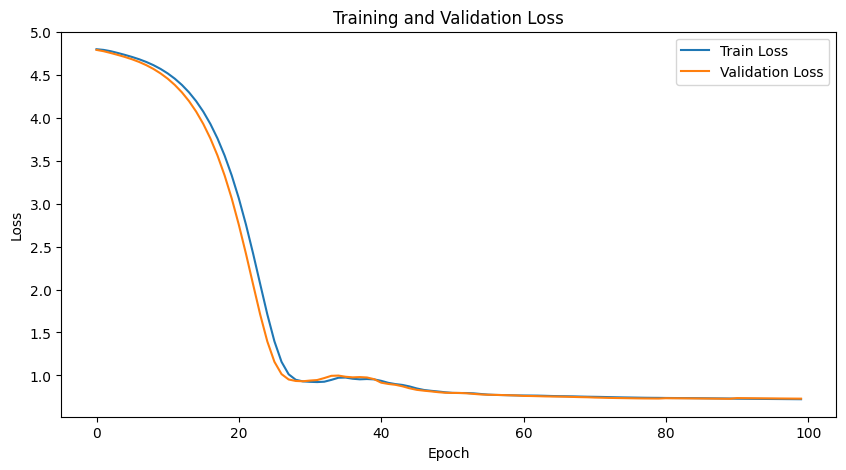

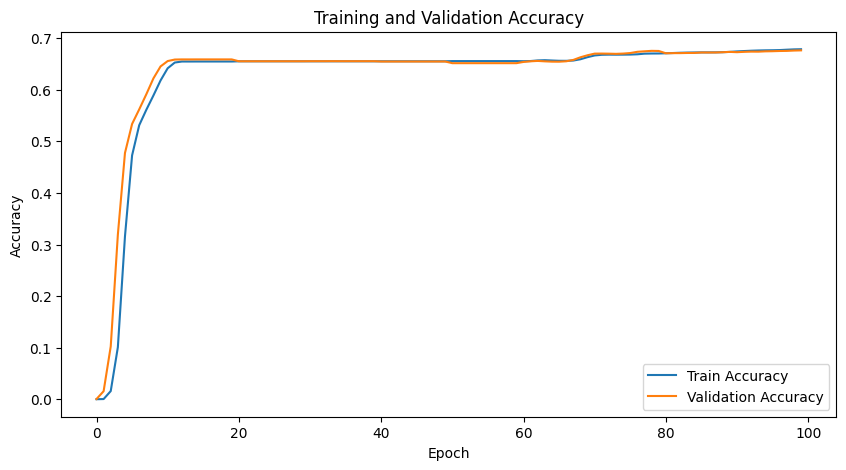

In [56]:


# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plotting the accuracies
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
val_preds

NameError: ignored

In [ ]:
y_val_fold

In [ ]:
class EarlyStopping:
    def __init__(self, tolerance, min_delta):
        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, validation_loss):
        if (validation_loss - train_loss) > self.min_delta:
            self.counter +=1
            if self.counter >= self.tolerance:
                self.early_stop = True

early_stopping = EarlyStopping(tolerance=5, min_delta=0.01)

# training
num_epochs = 20
for train_index, val_index in kf.split(X_train):
    print(train_index)
    X_train_fold = X_train.values[train_index]
    y_train_fold = y_train.values[train_index]
    X_val_fold = X_train.values[val_index]
    y_val_fold = y_train.values[val_index]

    for epoch in range(num_epochs):
        out = model(torch.from_numpy(X_train_fold).float())
        loss = criterion(out, y_train_fold)



        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print (f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

        with torch.no_grad():  # Evaluation mode, no need to compute gradients
            val_outputs = model(X_val_fold)
            # val_loss = criterion(val_outputs, y_val_fold)
            val_loss = criterion(val_outputs, torch.from_numpy(y_val_fold).long())

            _, val_preds = torch.max(val_outputs, 1)
            val_accuracy = accuracy_score(y_val_fold.cpu(), val_preds.cpu())

            print(f'Validation Loss: {val_loss.item()}, Validation Accuracy: {val_accuracy}')

            # Check for early stopping
            early_stopping(loss.item(), val_loss.item())
            if early_stopping.early_stop:
                print('Early stopping triggered...')
                break

    # If early stopping was triggered, break the outer loop as well
    if early_stopping.early_stop:
        break
